In [8]:
import torch
import os
import shutil
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from torchvision import transforms
from pathlib import Path
from typing import List, Dict, Any


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes: 0, 90, 180, 270

# Load saved weights
checkpoint = torch.load("checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
CROPS_DIR = Path("../data/rotation/classification/test")

In [3]:

ALL_ANGLES_CROPS = Path("../data/rotation/classification/all_angles_from_test")

os.makedirs("../data/rotation/classification/all_angles_from_test", exist_ok=True)

for p in CROPS_DIR.iterdir():
    print(p)
    
    for f in p.iterdir():
        print(f.name)

        shutil.move(f, ALL_ANGLES_CROPS / f.name)

FileNotFoundError: [Errno 2] No such file or directory: '../data/rotation/classification/test'

In [4]:
for f in ALL_ANGLES_CROPS.iterdir():
    print(f.name)
    if ("_45.png" in f.name):
        os.remove(f)

## Move crops from cad crops clean to test crops in order to test inference

In [11]:

CAD_CROPS_CLEAN = Path("../data/cad_crops/")
TEST_CROPS = Path("../data/test_crops")


for p in CAD_CROPS_CLEAN.iterdir():
    if (".jpg" in p.name):
        print(p)
        shutil.move(p, TEST_CROPS / p.name)

../data/cad_crops/4_01393_crop_0.jpg
../data/cad_crops/1_02138_crop_0.jpg
../data/cad_crops/0_12000_crop_0.jpg
../data/cad_crops/4_06556_crop_0.jpg
../data/cad_crops/3_01064_crop_0.jpg
../data/cad_crops/6_00415_crop_0.jpg
../data/cad_crops/4_03549_crop_0.jpg
../data/cad_crops/4_02755_crop_0.jpg
../data/cad_crops/c52fb089-f312-4688-b9a0-9017d357557a_crop_0.jpg
../data/cad_crops/4a0e6c10-77c7-4ca4-a92b-569e7edcc325_crop_0.jpg
../data/cad_crops/2_02063_crop_0.jpg
../data/cad_crops/11dc141d-b526-48e6-bdcc-7078ef257e78_crop_0.jpg
../data/cad_crops/29d552ae-018d-4cec-ad19-f0ad0d80abdb_crop_0.jpg
../data/cad_crops/4_06049_crop_0.jpg
../data/cad_crops/5_00051_crop_0.jpg
../data/cad_crops/2_03002_crop_0.jpg
../data/cad_crops/0_06587_crop_0.jpg
../data/cad_crops/f08fa2f6-d15c-4828-b6dc-72bfe8f37228_crop_0.jpg
../data/cad_crops/4_03734_crop_0.jpg
../data/cad_crops/9a753c1c-f073-47dc-948a-5f74c98ed814_crop_0.jpg
../data/cad_crops/4_03725_crop_2.jpg
../data/cad_crops/aa54e96a-f110-4c7d-b52c-5e0dbc2

In [12]:
import cv2
from pathlib import Path
import numpy as np
from collections import defaultdict

def rotate_patch(patch: np.ndarray, angle: int) -> np.ndarray:
    h, w = patch.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    cos, sin = abs(M[0, 0]), abs(M[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)
    M[0, 2] += new_w / 2 - w / 2
    M[1, 2] += new_h / 2 - h / 2

    border = (0, 0, 0, 0) if patch.shape[2] == 4 else (255, 255, 255)
    return cv2.warpAffine(
        patch,
        M,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=border
    )

# Config
TEST_CROPS = Path("../data/test_crops")
NEW_ANGLES = [90, 180, 270]
ANGLE_SUFFIXES = [0] + NEW_ANGLES
VALID_EXTS = {".jpg", ".jpeg", ".png"}

def standardize_and_rotate():
    # Step 1: count files before
    files_before = list(TEST_CROPS.glob("*"))
    original_img_count = len([f for f in files_before if f.suffix.lower() in VALID_EXTS])

    print(f"\n📸 Images before processing: {original_img_count}")

    # Process each image
    for img_path in files_before:
        if not img_path.is_file() or img_path.suffix.lower() not in VALID_EXTS:
            continue

        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"⚠️ Failed to load {img_path}")
            continue

        base_name = img_path.stem.split("_")[0]
        new_name = f"{base_name}_0.png"
        new_path = TEST_CROPS / new_name

        cv2.imwrite(str(new_path), img)
        print(f"✅ Renamed/saved: {new_name}")

        for angle in NEW_ANGLES:
            out_name = f"{base_name}_{angle}.png"
            out_path = TEST_CROPS / out_name

            if not out_path.exists():
                rotated = rotate_patch(img, angle)
                cv2.imwrite(str(out_path), rotated)
                print(f"🌀 Rotated {angle}° -> {out_name}")

        # Delete old file if different from new path
        if img_path != new_path:
            img_path.unlink()

    # Step 2: count files after
    files_after = list(TEST_CROPS.glob("*.png"))
    final_count = len(files_after)

    # Step 3: group by base name
    base_to_angles = defaultdict(set)
    for f in files_after:
        parts = f.stem.split("_")
        if len(parts) == 2 and parts[1].isdigit():
            base, angle = parts
            base_to_angles[base].add(int(angle))

    expected_total = len(base_to_angles) * 4
    missing_images = expected_total - final_count

    print(f"\n🧮 Final stats:")
    print(f"➡️ Total unique base images: {len(base_to_angles)}")
    print(f"➡️ Expected image count (4 per base): {expected_total}")
    print(f"✅ Images after processing: {final_count}")
    print(f"❌ Missing images: {missing_images}")

if __name__ == "__main__":
    standardize_and_rotate()



📸 Images before processing: 18388
✅ Renamed/saved: 4_0.png
🌀 Rotated 90° -> 4_90.png
🌀 Rotated 180° -> 4_180.png
🌀 Rotated 270° -> 4_270.png
✅ Renamed/saved: 1_0.png
🌀 Rotated 90° -> 1_90.png
🌀 Rotated 180° -> 1_180.png
🌀 Rotated 270° -> 1_270.png
✅ Renamed/saved: 0_0.png
🌀 Rotated 90° -> 0_90.png
🌀 Rotated 180° -> 0_180.png
🌀 Rotated 270° -> 0_270.png
✅ Renamed/saved: 4_0.png
✅ Renamed/saved: 3_0.png
🌀 Rotated 90° -> 3_90.png
🌀 Rotated 180° -> 3_180.png
🌀 Rotated 270° -> 3_270.png
✅ Renamed/saved: 6_0.png
🌀 Rotated 90° -> 6_90.png
🌀 Rotated 180° -> 6_180.png
🌀 Rotated 270° -> 6_270.png
✅ Renamed/saved: 4_0.png
✅ Renamed/saved: 4_0.png
✅ Renamed/saved: c52fb089-f312-4688-b9a0-9017d357557a_0.png
🌀 Rotated 90° -> c52fb089-f312-4688-b9a0-9017d357557a_90.png
🌀 Rotated 180° -> c52fb089-f312-4688-b9a0-9017d357557a_180.png
🌀 Rotated 270° -> c52fb089-f312-4688-b9a0-9017d357557a_270.png
✅ Renamed/saved: 4a0e6c10-77c7-4ca4-a92b-569e7edcc325_0.png
🌀 Rotated 90° -> 4a0e6c10-77c7-4ca4-a92b-569e7ed

In [16]:


transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Match training resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Test Inference Model with rotated Data in test_crops

❌ 80040776-18be-48b6-aa8f-f660b1cc690f_0.png | GT: 0°, Pred: 180°


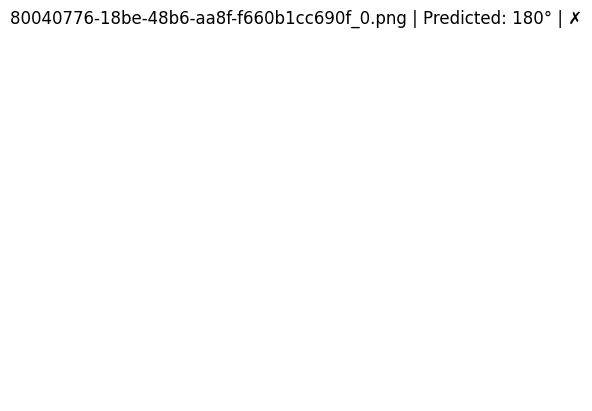

❌ a546bf6c-c047-4127-b2fc-8aa82321f6f5_180.png | GT: 180°, Pred: 0°


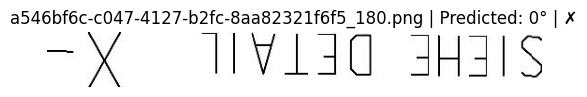

❌ d946cec6-3028-414f-8bfc-3e06f2fa060a_180.png | GT: 180°, Pred: 270°


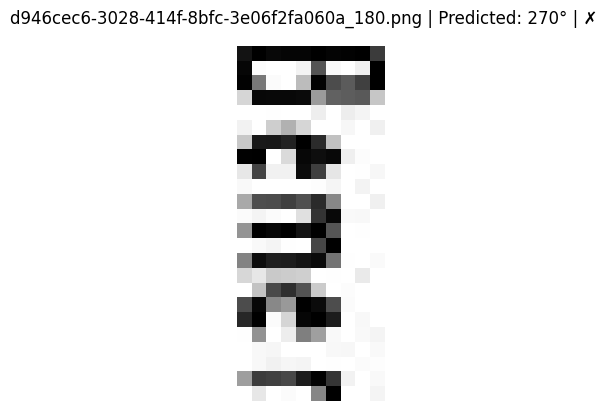

❌ 41583094-39cf-43a9-af75-f3e68c8096f9_180.png | GT: 180°, Pred: 0°


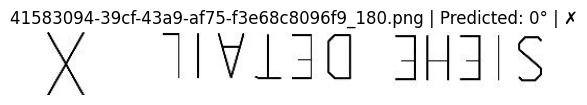

❌ d11f3435-d87c-49e3-855c-9f954757d839_90.png | GT: 90°, Pred: 180°


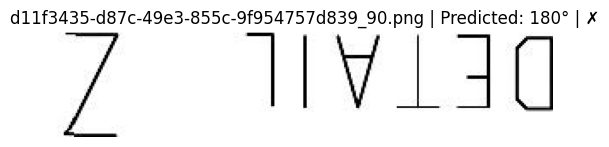

❌ 23e873b2-9508-49fb-a6ba-8abc8d46f071_180.png | GT: 180°, Pred: 0°


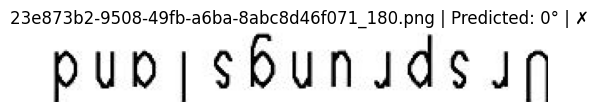

❌ f9671ce1-9cc4-4f8a-a29c-043a3c10d102_270.png | GT: 270°, Pred: 0°


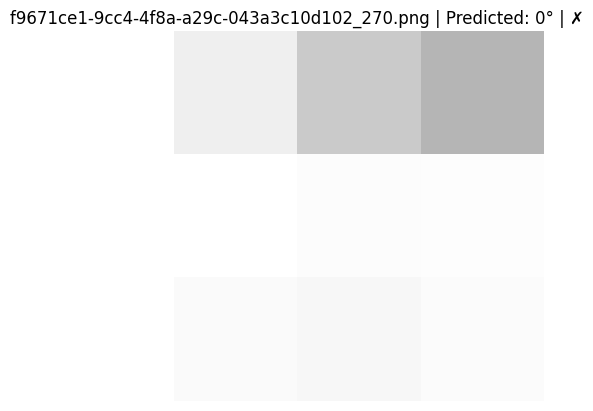

❌ 2db8aded-3a12-4f36-bed4-2b65ba66d01c_180.png | GT: 180°, Pred: 0°


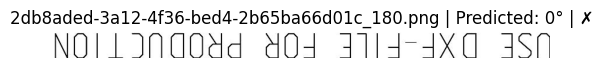

❌ 55d20c81-f701-4262-b10c-2fbbc5c296c8_270.png | GT: 270°, Pred: 90°


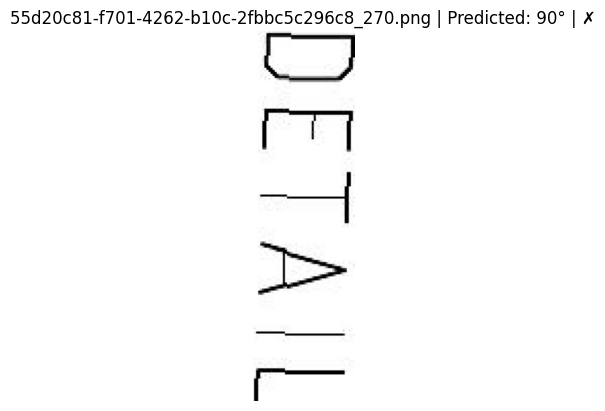

❌ a4049676-097c-40b1-a18e-eb5169bcb38a_180.png | GT: 180°, Pred: 0°


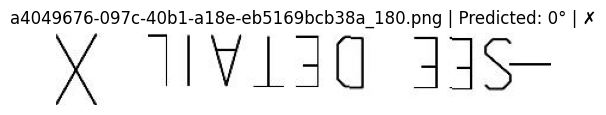

❌ 01e07876-e038-4bf8-8124-18b128ecd724_90.png | GT: 90°, Pred: 180°


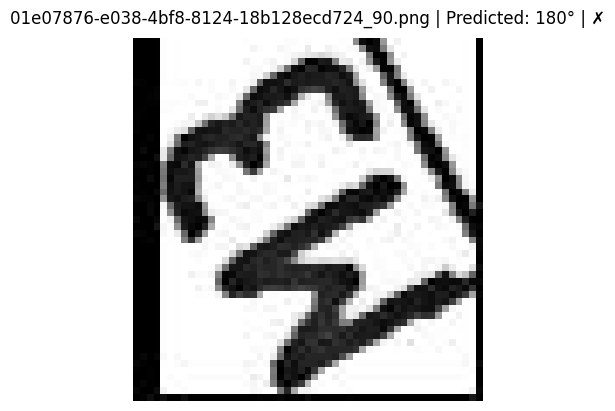

❌ 616429e9-191d-4306-b742-b80cd2dde737_180.png | GT: 180°, Pred: 0°


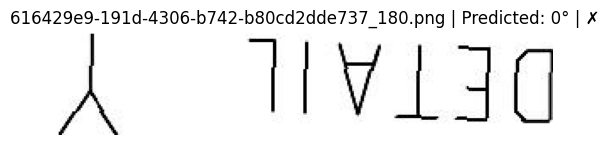

❌ f3a9c917-eb84-4fea-99de-6c8bf7b81be6_0.png | GT: 0°, Pred: 90°


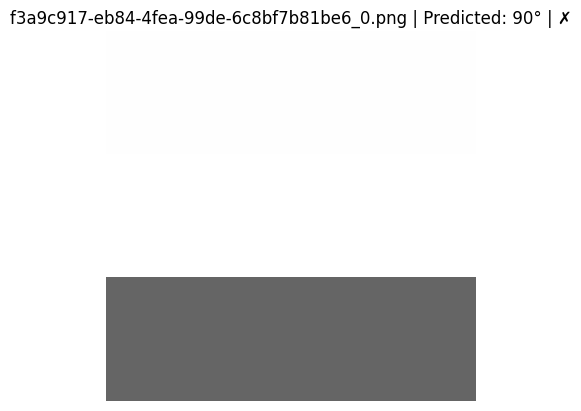

❌ d75f2d06-10a9-4991-87ed-f065e4ce02e8_180.png | GT: 180°, Pred: 0°


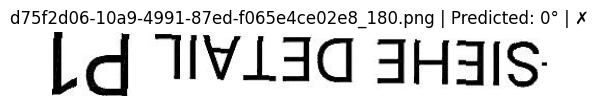

❌ 4b5b4ccf-579d-4b49-a500-a6ac0f2a3732_180.png | GT: 180°, Pred: 0°


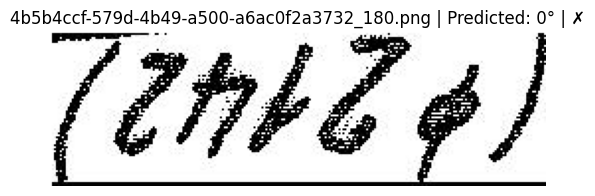

❌ 0184fc8b-2bbe-4770-946f-b7ef91f57b00_270.png | GT: 270°, Pred: 0°


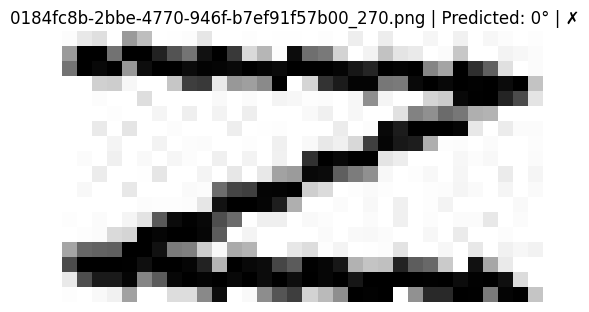

❌ b56e1d1f-6aeb-4cbb-a587-447884e71044_270.png | GT: 270°, Pred: 90°


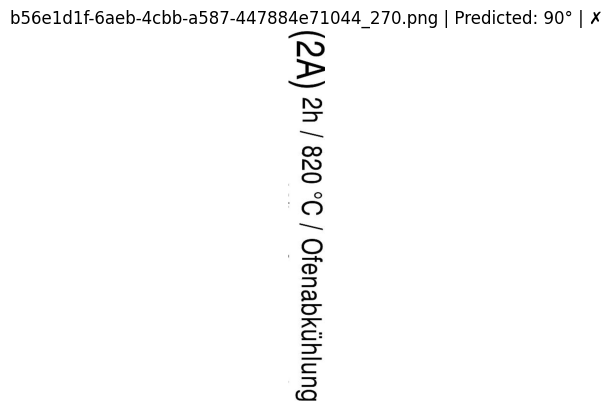

❌ 429fbac2-e257-4ad6-9508-dad023d2529f_180.png | GT: 180°, Pred: 0°


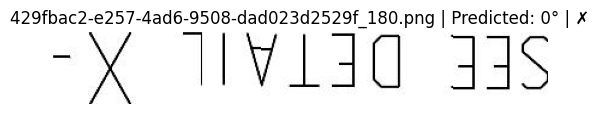

❌ 184a5486-6804-4eb5-921c-3e8f6f09cbd5_180.png | GT: 180°, Pred: 0°


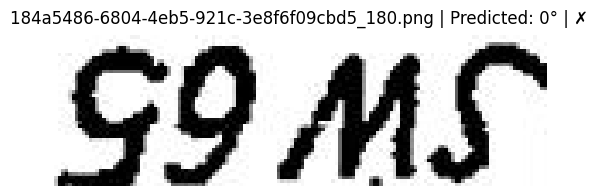

❌ eb4c39ea-a109-4fbf-9c39-690918fd7032_180.png | GT: 180°, Pred: 270°


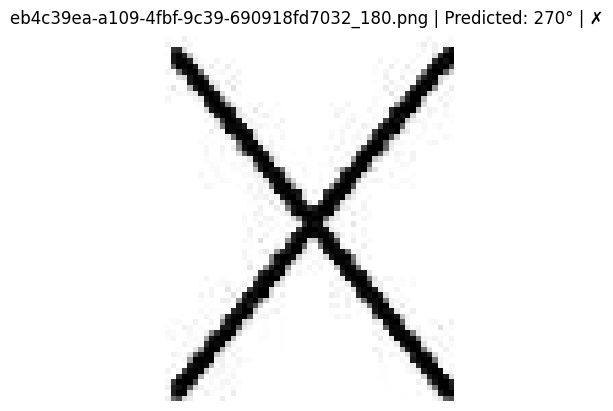

❌ d946cec6-3028-414f-8bfc-3e06f2fa060a_90.png | GT: 90°, Pred: 0°


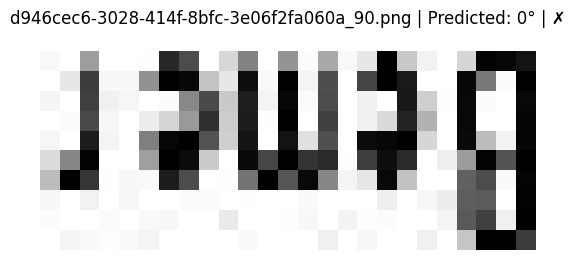

❌ 63fb78af-9885-4f6f-a186-8dd9ce596c6a_270.png | GT: 270°, Pred: 90°


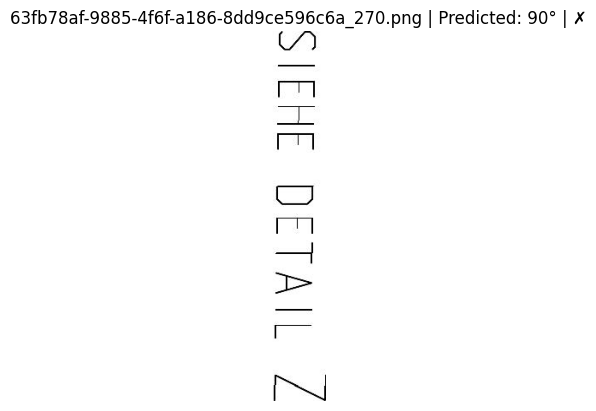

❌ acc77483-ff97-406a-8512-380bf92485ca_180.png | GT: 180°, Pred: 0°


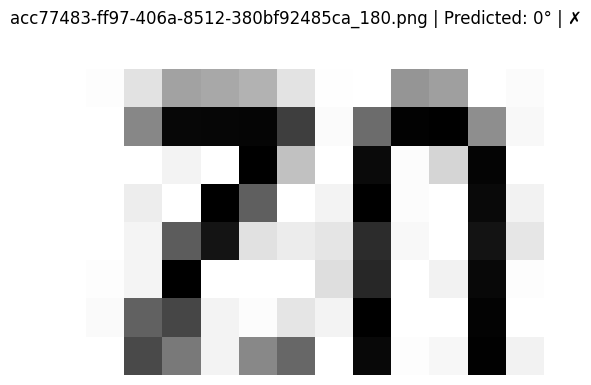

❌ 2e928df8-5200-4900-b108-d0c37304fdf1_180.png | GT: 180°, Pred: 0°


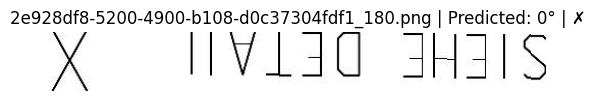

❌ 3fc2cd48-42f4-47a5-b0c6-15b9953a5e39_90.png | GT: 90°, Pred: 180°


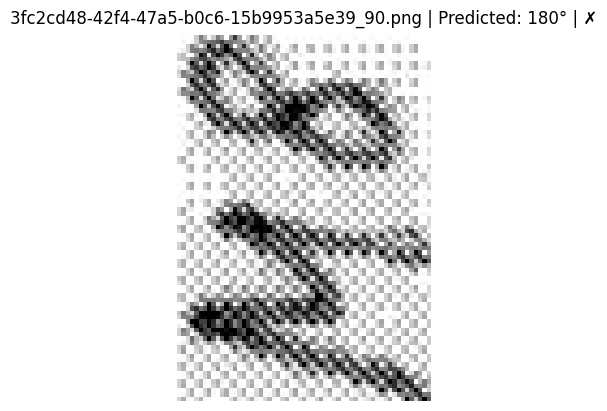

❌ d7111d58-3107-47b8-ab9f-bc99d104f34c_180.png | GT: 180°, Pred: 0°


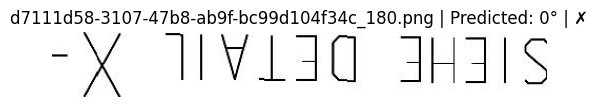

❌ 80af1db1-3e6f-4a59-bf32-2e09fdc75ec7_270.png | GT: 270°, Pred: 90°


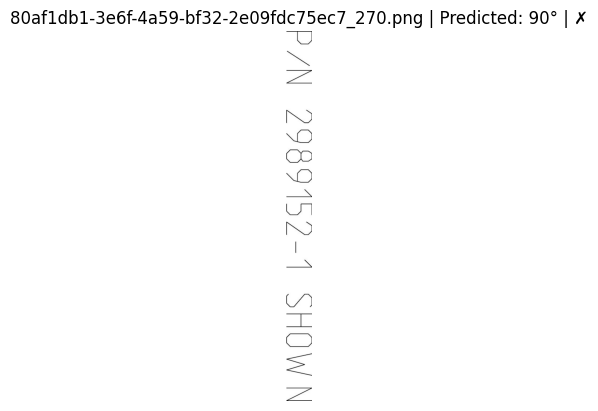

❌ 12fc5699-0464-4117-a80e-4b3822d08bd5_270.png | GT: 270°, Pred: 90°


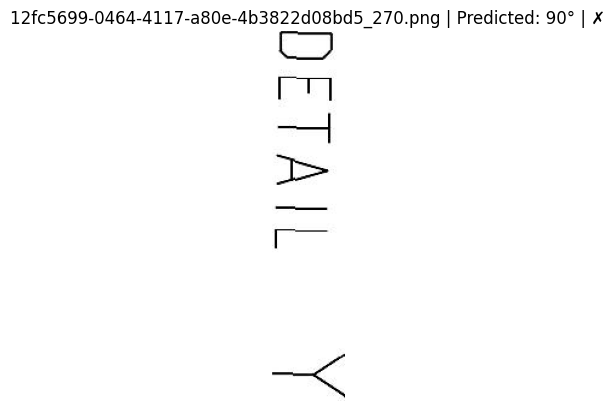

❌ 1f990ea0-12bd-4120-a45b-4ba38bad117f_180.png | GT: 180°, Pred: 0°


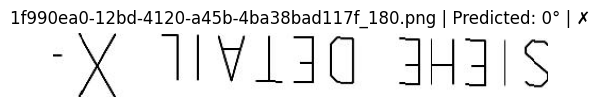

❌ 7a600f7d-971a-45d8-93bf-2021560ce2dc_0.png | GT: 0°, Pred: 180°


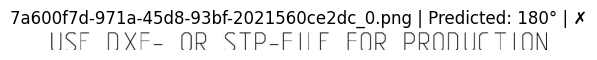

🧮 Total angular error: 18180°, Incorrect predictions: 113/13196
🧮 Total angular error: 18180°, Incorrect predictions: 113/13196


In [17]:
from pathlib import Path
from PIL import Image
import torch
import cv2
import matplotlib.pyplot as plt

suffix = ".png"

def predict_images():
    CLASS_NAMES = [0, 180, 270, 90]

    total_angle_off = 0
    count = 0
    false_pred_count = 0
    printed_errors = 0
    max_to_print = 30
    logs = []

    for f in TEST_CROPS.iterdir():
        if f.suffix.lower() != suffix:
            continue

        img = Image.open(f).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)

        pred_angle = CLASS_NAMES[predicted.item()]

        try:
            angle = int(f.stem.split("_")[-1])
        except ValueError:
            msg = f"⚠️ Could not extract angle from filename: {f.name}"
            print(msg)
            logs.append(msg)
            continue

        angle_diff = (pred_angle - angle) % 360
        angle_diff = min(angle_diff, 360 - angle_diff)
        total_angle_off += angle_diff

        correct = (angle == pred_angle)
        if not correct:
            false_pred_count += 1
            msg = f"❌ {f.name} | GT: {angle}°, Pred: {pred_angle}°"
            logs.append(msg)

            if printed_errors < max_to_print:
                print(msg)
                plt.imshow(img)
                plt.title(f"{f.name} | Predicted: {pred_angle}° | ✗")
                plt.axis("off")
                plt.show()
                printed_errors += 1

        count += 1

    summary = f"🧮 Total angular error: {total_angle_off}°, Incorrect predictions: {false_pred_count}/{count}"
    print(summary)
    logs.append(summary)

    # Speichere alles in Log-Datei
    with open("prediction_log.txt", "w", encoding="utf-8") as f_out:
        f_out.write("\n".join(logs))

    return summary


if __name__ == "__main__":
    print(predict_images())
